In [226]:
import numpy as np
from sklearn.manifold import TSNE
import random

from itertools import permutations
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects

In [227]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

In [228]:
# load the face dataset
data = np.load('14-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (220, 128) (220,) (70, 128) (70,)


In [229]:
print(testy)

['anne_hathaway' 'anne_hathaway' 'anne_hathaway' 'anne_hathaway'
 'anne_hathaway' 'anne_hathaway' 'arnold_schwarzenegger'
 'arnold_schwarzenegger' 'arnold_schwarzenegger' 'arnold_schwarzenegger'
 'arnold_schwarzenegger' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'dwayne_johnson' 'dwayne_johnson'
 'dwayne_johnson' 'dwayne_johnson' 'dwayne_johnson' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'kate_beckinsale' 'kate_beckinsale' 'kate_beckinsale' 'kate_beckinsale'
 'keanu_reeves' 'keanu_reeves' 'keanu_reeves' 'keanu_reeves'
 'keanu_reeves' 'lauren_cohan' 'lauren_cohan' 'lauren_cohan'
 'lauren_cohan' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling'
 'mindy_kaling' 'simon_pegg' 'simon_pegg' 'simon_pegg' 'simon_pegg'
 'simon_pegg' 'sofia_vergara' 'sofia_vergara' 'sofia_vergara'
 'sofia_vergara' 'sofia_

In [230]:
# converting textual labels into numeric labels
name = np.unique(testy)
map_name = {name[idx]: idx for idx in range(name.shape[0])}
print(map_name)
testy = np.array([map_name[testy[i]] for i in range(testy.shape[0])])
print(testy)
trainy = np.array([map_name[trainy[i]] for i in range(trainy.shape[0])])
print(trainy)

{'anne_hathaway': 0, 'arnold_schwarzenegger': 1, 'ben_afflek': 2, 'dwayne_johnson': 3, 'elton_john': 4, 'jerry_seinfeld': 5, 'kate_beckinsale': 6, 'keanu_reeves': 7, 'lauren_cohan': 8, 'madonna': 9, 'mindy_kaling': 10, 'simon_pegg': 11, 'sofia_vergara': 12, 'will_smith': 13}
[ 0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4
  4  4  5  5  5  5  5  6  6  6  6  7  7  7  7  7  8  8  8  8  9  9  9  9
  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10

In [231]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 14))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(14):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
#         print(labels)
#         print(x[np.array(labels) == i])
#         break
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

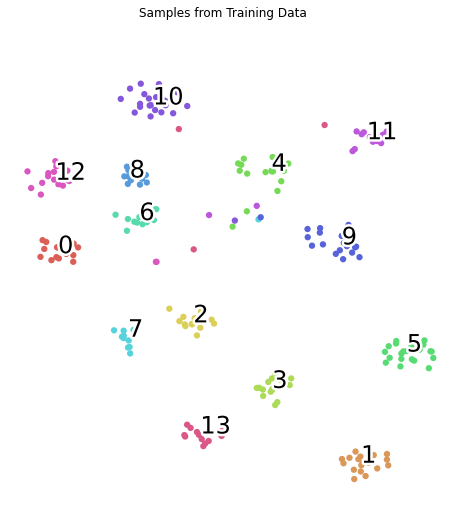

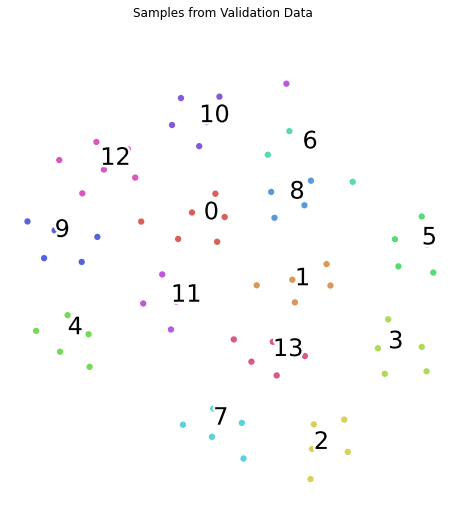

In [232]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(trainX)
scatter(train_tsne_embeds,trainy, "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(testX)
scatter(eval_tsne_embeds, testy, "Samples from Validation Data")

In [233]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [234]:
X_train, X_test = generate_triplet(trainX,trainy, ap_pairs=10, an_pairs=10,testsize=0.2)

In [235]:
X_train.shape

(1120, 3, 128)

In [236]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [263]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model= Sequential()
#     model.add(Input(shape=in_dims))
#     model.add(Flatten(name='flatten'))
#     model.add(Dense(64, activation="relu", name="layer1"))
#     model.add(Dense(32, activation="relu", name="layer2"))
    model.add(Dense(32, activation="softmax", name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [264]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)

In [265]:
anchor_input = Input((128, ), name='anchor_input')
positive_input = Input((128, ), name='positive_input')
negative_input = Input((128, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([128,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

y_pred.shape =  Tensor("merged_layer_22/concat:0", shape=(None, 96), dtype=float32)


In [266]:
model.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 128)          0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 128)          0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 128)          0                                            
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 32)           4128        anchor_input[0][0]               
                                                                 positive_input[0][0]      

In [267]:
Anchor = X_train[:,0,:].reshape((-1,128))
Positive = X_train[:,1,:].reshape((-1,128))
Negative = X_train[:,2,:].reshape((-1,128))
Anchor_test = X_test[:,0,:].reshape((-1,128))
Positive_test = X_test[:,1,:].reshape((-1,128))
Negative_test = X_test[:,2,:].reshape((-1,128))
print(Anchor_test.shape)

(280, 128)


In [268]:
Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))
model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=5, epochs=50)

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 0s 249us/step - loss: 0.3325 - val_loss: 0.3214
Epoch 2/50
1120/1120 [==============================] - 0s 169us/step - loss: 0.3253 - val_loss: 0.3158
Epoch 3/50
1120/1120 [==============================] - 0s 170us/step - loss: 0.3176 - val_loss: 0.3095
Epoch 4/50
1120/1120 [==============================] - 0s 173us/step - loss: 0.3093 - val_loss: 0.3025
Epoch 5/50
1120/1120 [==============================] - 0s 196us/step - loss: 0.3004 - val_loss: 0.2946
Epoch 6/50
1120/1120 [==============================] - 0s 184us/step - loss: 0.2909 - val_loss: 0.2857
Epoch 7/50
1120/1120 [==============================] - 0s 169us/step - loss: 0.2806 - val_loss: 0.2758
Epoch 8/50
1120/1120 [==============================] - 0s 165us/step - loss: 0.2697 - val_loss: 0.2653
Epoch 9/50
1120/1120 [==============================] - 0s 169us/step - loss: 0.2580 - val_loss: 0.2537
Epoch 10/50
1120/

In [269]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

In [270]:
trained_model.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
anchor_input (InputLayer)    (None, 128)               0         
_________________________________________________________________
sequential_23 (Sequential)   (None, 32)                4128      
Total params: 4,128
Trainable params: 4,128
Non-trainable params: 0
_________________________________________________________________


In [271]:
tsne = TSNE()
X_train_trm = trained_model.predict(trainX)
X_test_trm = trained_model.predict(testX)
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

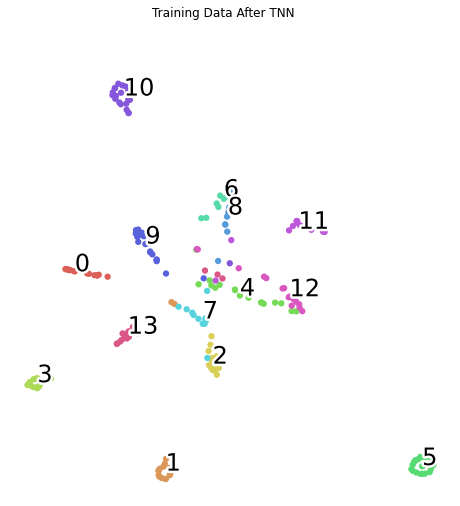

In [272]:
scatter(train_tsne_embeds, trainy, "Training Data After TNN")

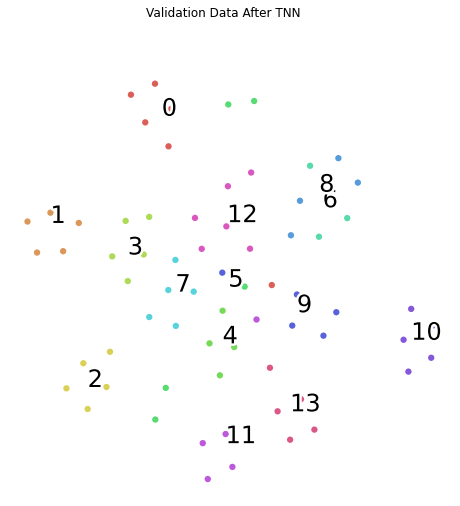

In [273]:
scatter(eval_tsne_embeds, testy, "Validation Data After TNN")

In [274]:
model.weights

[<tf.Variable 'sequential_23/embeddings/kernel:0' shape=(128, 32) dtype=float32, numpy=
 array([[-0.14248402, -0.08263049, -0.11905068, ..., -0.17668237,
         -0.11191001,  0.00972924],
        [-0.01377694, -0.17091492,  0.02839626, ..., -0.19818524,
         -0.1994733 , -0.08474538],
        [-0.14281482,  0.20522909, -0.07215367, ...,  0.12003712,
         -0.18651   ,  0.18457374],
        ...,
        [-0.01105389,  0.04598062, -0.02172025, ...,  0.03538995,
          0.04912625, -0.05129797],
        [ 0.05167175,  0.00740717, -0.06148607, ..., -0.15779307,
         -0.06022485,  0.18801631],
        [ 0.12205248, -0.14673653, -0.10525499, ..., -0.16361356,
         -0.06323584, -0.04684622]], dtype=float32)>,
 <tf.Variable 'sequential_23/embeddings/bias:0' shape=(32,) dtype=float32, numpy=
 array([ 0.02284076, -0.05803113, -0.04458868,  0.01170626,  0.02783893,
         0.00265429, -0.07015231,  0.03101889, -0.07425024, -0.0080344 ,
         0.01744328,  0.01915003, -0.0072

In [281]:
e = np.expand_dims(testX[35],axis = 0)
e = trained_model.predict(e)
# e1 = np.expand_dims(testX[i],axis = 0)
# e1 = trained_model.predict(e1)
# print(e.shape)
# mul = np.matmul(e,np.transpose(e1))
# print(mul)
# print(np.cos(mul))
# print(np.linalg.norm(mul))
#0.4
for i in range(70):
    e1 = np.expand_dims(testX[i],axis = 0)
    e1 = trained_model.predict(e1)
    print(np.linalg.norm(e-e1))

0.7501013
0.810335
0.42710593
0.5712303
0.9166419
0.8051598
0.9241291
0.87136424
0.64567715
0.71095747
0.9212915
0.5880439
0.5023133
0.54576856
0.41069072
0.66608506
0.5850044
0.47756335
0.47122896
0.55216557
0.4041525
0.6187141
0.53596663
0.5605806
0.6285462
0.58614063
0.8543997
0.41325822
0.8762085
0.9677575
0.8736162
0.6579828
0.6016613
0.6314981
0.51663905
0.0
0.210786
0.2055679
0.2535737
0.2262679
0.5647509
0.76262903
0.7869498
0.46795908
0.37933284
0.90514684
0.5294948
0.8087006
0.48260757
0.9562299
0.98445237
0.92960995
0.9209996
0.88062614
0.53546745
0.66472566
0.49562815
0.3903984
0.49918658
0.7448729
0.45927402
0.67554975
0.4748721
0.510582
0.5092221
0.8049369
0.6737674
0.6775053
0.4600113
0.6663481


In [256]:
np.linalg.norm(e-e1)

12.88951

In [126]:
# trained_model.save('trained_model.h5')

In [27]:
X_train_trm = trained_model.predict(trainX)
X_test_trm = trained_model.predict(testX)

Classifier_input = Input((16,))
Classifier_output = Dense(15, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm,trainy, validation_data=(X_test_trm,testy),epochs=10)


ValueError: Error when checking target: expected dense_2 to have shape (15,) but got array with shape (1,)

In [280]:
trained_model.save('soft_train.h5')